# **Lane Detect Assist**

## **Loc Dam**

In [166]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from calibration import load_calibration
from copy import copy
from IPython.display import Image


In [2]:
class Lane():
    def __init__(self):
        # was the line detected in the last frame or not
        self.detected = False
        #x values for detected line pixels
        self.cur_fitx = None
        #y values for detected line pixels
        self.cur_fity = None
        # x values of the last N fits of the line
        self.prev_fitx = []
        #polynomial coefficients for the most recent fit
        self.current_poly = [np.array([False])]
        #best polynomial coefficients for the last iteration
        self.prev_poly = [np.array([False])]

    def average_pre_lanes(self):
        tmp = copy(self.prev_fitx)
        tmp.append(self.cur_fitx)
        self.mean_fitx = np.mean(tmp, axis=0)

    def append_fitx(self):
        if len(self.prev_fitx) == N:
            self.prev_fitx.pop(0)
        self.prev_fitx.append(self.mean_fitx)

    def process(self, ploty):
        self.cur_fity = ploty
        self.average_pre_lanes()
        self.append_fitx()
        self.prev_poly = self.current_poly


## **Parameters**

Define all the parameters needed for the project. 
First, since the highway lane width in US: 3.7 meters, define LANEWIDTH = 3.7


In [3]:
left_lane = Lane()
right_lane = Lane()
frame_width = 1280
frame_height = 720

LANEWIDTH = 3.7  
input_scale = 4
output_frame_scale = 4
N = 4 # buffer previous N lines

input_scale = 4
x = [194, 1117, 705, 575]
y = [719, 719, 461, 461]
X = [290, 990, 990, 290]
Y = [719, 719, 0, 0]

src = np.floor(np.float32([[x[0], y[0]], [x[1], y[1]],[x[2], y[2]], [x[3], y[3]]]) / input_scale)
dst = np.floor(np.float32([[X[0], Y[0]], [X[1], Y[1]],[X[2], Y[2]], [X[3], Y[3]]]) / input_scale)

M = cv2.getPerspectiveTransform(src, dst)


M_inv = cv2.getPerspectiveTransform(dst, src)

# Only for creating the final video visualization
X_b = [574, 706, 706, 574]
Y_b = [719, 719, 0, 0]
src_ = np.floor(np.float32([[x[0], y[0]], [x[1], y[1]],[x[2], y[2]], [x[3], y[3]]]) / (input_scale*2))
dst_ = np.floor(np.float32([[X_b[0], Y_b[0]], [X_b[1], Y_b[1]],[X_b[2], Y_b[2]], [X_b[3], Y_b[3]]]) / (input_scale*2))
M_b = cv2.getPerspectiveTransform(src_, dst_)
# Only for creating the final video visualization

# Threshold for color and gradient thresholding
s_thresh, sx_thresh, dir_thresh, m_thresh, r_thresh = (120, 255), (20, 100), (0.7, 1.3), (30, 100), (200, 255)

# load the calibration
calib_file = 'camera_cal/calibration_pickle.p'
mtx, dist = load_calibration(calib_file)





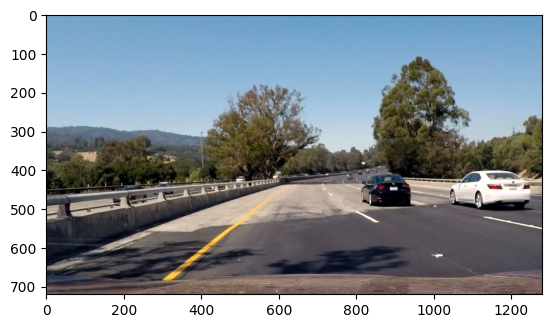

In [170]:
imagepath = 'examples/test4.jpg'

img = cv2.imread(imagepath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

#abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255))

### **Convert image to binary array and isolate the details**

### **Funtion abs_sobel_thresh**

First we convert the image/ frame to grayscale. Then we use cv2.Sobel to calculate the derivative of an image (curves of that image), or in this case is the gradient with restpect to x and y sperately.

In [5]:
Image(url = "sobel.jpg")

In [78]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):

    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))

    
    scaled_sobel = np.uint8(255.*abs_sobel/np.max(abs_sobel))

    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output

In [182]:
a = abs_sobel_thresh(img)
a

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

### **Function mag_thresh**

Then calculate the **magnitude** of those gradients then scale it down to 8-bit by divide it by 255. Then convert to uint8 for further computing, name this array "gradmag"

Next, use cv2.zero_like to return the zero array same as the the gradmag. Generate the binary output of the image when it meets the given threshhold.

In [80]:
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):

    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    
    gradmag = np.sqrt(sobelx**2 + sobely**2)

    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)

    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    return binary_output


In [81]:
A = mag_thresh(img)
A

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

### **Function dir_threshold**

Define a function that does almost the same as mag_threh. The only different is the calculation of the **direction** of those gradients base on the threshold after taking absolute value of those gradients. 

In [82]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    

    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

    
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output


In [83]:
B = dir_threshold(img)
B

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

### **Combine dir_threshold and mag_thresh into gradient_pipeline**

Define function gradient_pipeline that combine both **mag_thresh** and **dir_threshold** to return the **gray scale** of the image according to the given threshold

In [84]:
def gradient_pipeline(image, ksize = 3, sx_thresh=(20, 100), sy_thresh=(20, 100), m_thresh=(30, 100), dir_thresh=(0.7, 1.3)):

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=sx_thresh)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=sy_thresh)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, thresh=m_thresh)
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=dir_thresh)
    combined = np.zeros_like(mag_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    # combined[(gradx == 1)  | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1be11b9e470>)

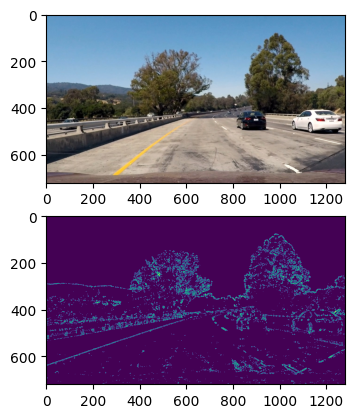

In [185]:
C = gradient_pipeline(img)
plt.subplot(2,1,1),plt.imshow(img)
plt.subplot(2,1,2),plt.imshow(C)

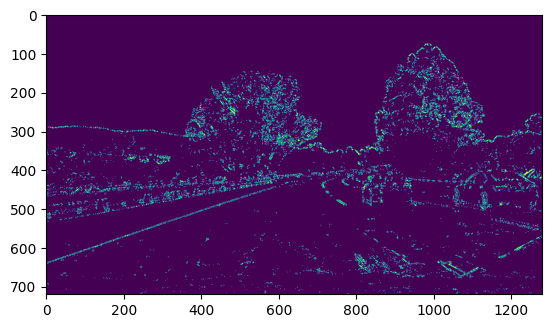

In [187]:
plt.imshow(C)

In [86]:
def threshold_col_channel(channel, thresh):

    binary = np.zeros_like(channel)
    binary[(channel >= thresh[0]) & (channel <= thresh[1])] = 1

    return binary


## **Function find_edges**

Define function find_edges that first convert the image to **HLS space**.

We use HLS space instead of RGB because we need to ulilize the S channel to highlight the yellow color lane.

The HLS channel converts the image into a hue, saturation, and lightness components instead of the RGB representation. The Hue is the color of the image, the Saturation is the pureness of the hue color, and the lightness is the strength of the hue.    

Here is an example

In [87]:
Image(url = "hls.png")

Calculate the absolute sobel (gradient) in x direction. In order to detect the **yellow** lane, we need to highlight that color by adding more **weight** to the **S channel** in HLS. In particular, change the "1" in the binary output to "2"

In [88]:
def find_edges(img, s_thresh=s_thresh, sx_thresh=sx_thresh, dir_thresh=dir_thresh):

    img = np.copy(img)
    # Convert to HLS color space and threshold the s channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float64)
    s_channel = hls[:,:,2]
    s_binary = threshold_col_channel(s_channel, thresh=s_thresh)

    # Sobel x
    sxbinary = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=sx_thresh)
    mag_binary = mag_thresh(img, sobel_kernel=3, thresh=m_thresh)
    # # gradient direction
    dir_binary = dir_threshold(img, sobel_kernel=3, thresh=dir_thresh)
    #
    # # output mask
    combined_binary = np.zeros_like(s_channel)
    combined_binary[(( (sxbinary == 1) & (dir_binary==1) ) | ( (s_binary == 1) & (dir_binary==1) ))] = 1

    # add more weights for the s channel
    c_bi = np.zeros_like(s_channel)
    c_bi[( (sxbinary == 1) & (s_binary==1) )] = 2

    ave_binary = (combined_binary + c_bi)

    return ave_binary


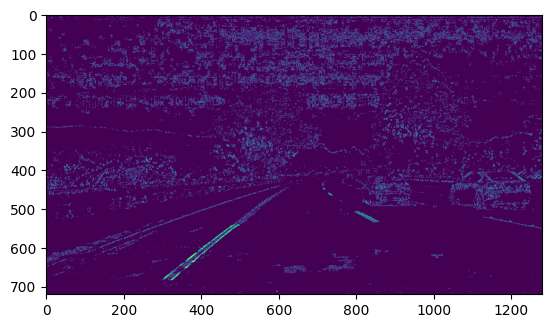

In [173]:
D = find_edges(img)
plt.imshow(D)


This highlight the yellow lane. However, the background also highlighted, which we do not need.

### **Obtain birdview**

Use **cv2.getPerspectiveTransform()** and **cv2.warpPerspective** to  **"rotate"** image into bird view.
In order to do this, first set 4 predeterined source points, and then determine their destination points according to the **birdview** that we want. 

Here is a illustrate for example:


In [90]:
Image(url = "transform.png" )

In [117]:
# screen size: 1280x720
input_scale = 4
x = [194, 1117, 705, 575]
y = [719, 719, 461, 461]
X = [290, 990, 990, 290]
Y = [719, 719, 0, 0]

src = np.floor(np.float32([[x[0], y[0]], [x[1], y[1]],[x[2], y[2]], [x[3], y[3]]]) / input_scale)
dst = np.floor(np.float32([[X[0], Y[0]], [X[1], Y[1]],[X[2], Y[2]], [X[3], Y[3]]]) / input_scale)

M = cv2.getPerspectiveTransform(src, dst)


(<matplotlib.image.AxesImage at 0x1be14036f20>, (-0.5, 1279.5, 719.5, -0.5))

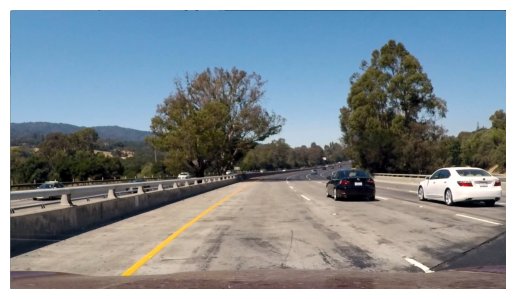

In [190]:
plt.imshow(img), plt.axis("off")

In [180]:
src, dst

(array([[ 48., 179.],
        [279., 179.],
        [176., 115.],
        [143., 115.]], dtype=float32),
 array([[ 72., 179.],
        [247., 179.],
        [247.,   0.],
        [ 72.,   0.]], dtype=float32))

In [123]:
def warper(img, M):
   
    
    img_size = (img.shape[1], img.shape[0]) # img_size = 1280*720
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped


(<AxesSubplot:title={'center':'Original Image'}>,
 Text(0.5, 1.0, 'Original Image'),
 (-0.5, 1279.5, 719.5, -0.5))

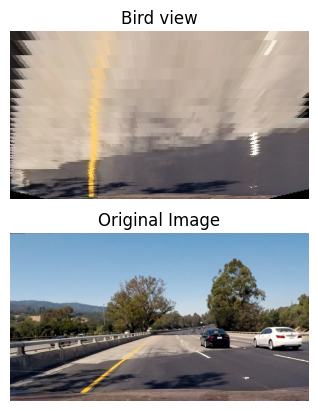

In [175]:


img_undist_ = cv2.undistort(img, mtx, dist, None, mtx)
img_undist = cv2.resize(img_undist_, (0,0), fx=1/input_scale, fy=1/input_scale)
img_binary = find_edges(img_undist)

binary_warped = warper(img_binary, M)
E = warper(img_undist, M)


plt.subplot(2,1,1),plt.imshow(E, cmap='gray'),plt.title("Bird view"),plt.axis('off')
plt.subplot(2,1,2),plt.imshow(img),plt.title("Original Image"),plt.axis('off')



### **Find left and right lane**

In order to find the left lane and right lane, we depend on the histogram of the binary wapred image. Since the original one contains background and other irrelevant pixles, we only deal with the bird view image in binary. And before we look at the histogram of the image, we stack multiple mask layer of binary_warp to highlight the lanes.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


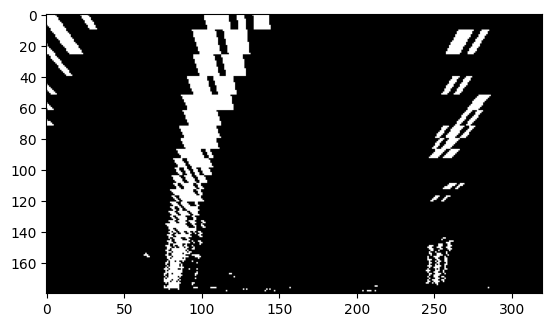

In [143]:

out_img = np.dstack((L, L, L))*255
out_img
plt.imshow(out_img)

Now plot the histogram and observe its two highest peaks representing for two lanes.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<AxesSubplot:title={'center':'histogram of lane'}>,
 Text(0.5, 1.0, 'histogram of lane'),
 (-15.950000000000001, 334.95, -1287.75, 27042.75))

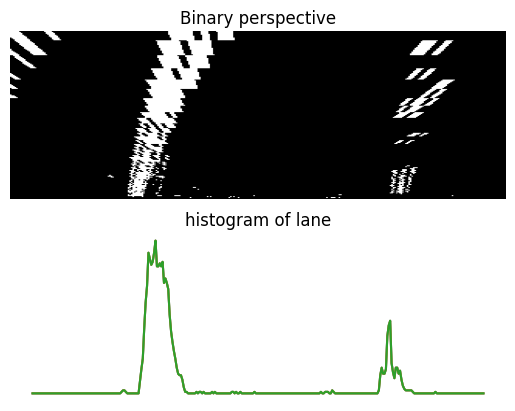

In [186]:
histogram = np.sum(out_img[np.int(out_img.shape[0]/2):,:], axis=0)
plt.subplot(2,1,1),plt.imshow(out_img, aspect='auto', cmap='gray'),plt.title("Binary perspective"),plt.axis('off')
plt.subplot(2,1,2),plt.plot(histogram),plt.title("histogram of lane"),plt.axis('off')

Clearly, the two peaks of the histogram according two lanes.

### **Determine the position of both lanes**

The idea to detect the lane is the detection of the pixle in the X direction when it has the peak of pixles.
1. Scan the pixle starting from left, then set the minimum number of pixle needed to set as center of the window. 
2. Determine all the nonzero points of the pixle
3. Trace the pixles in the Y direction, keep boxing the pixle in the windows from bottom to top.
4. Box those positions in a window. The dimension of the window is predetermined.


In [70]:

def full_search(binary_warped, visualization=False):

    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = out_img.astype('uint8')

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = np.floor(100/input_scale)
    # Set minimum number of pixels found to recenter window
    minpix = np.floor(50/input_scale)
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if visualization:
            cv2.rectangle(out_img,(int(win_xleft_low),int(win_y_low)),(int(win_xleft_high),int(win_y_high)),(0,255,0), 2)
            cv2.rectangle(out_img,(int(win_xright_low),int(win_y_low)),(int(win_xright_high),int(win_y_high)),(0,255,0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Visualization

    # Generate x and y values for plotting
    if visualization:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.subplot(1,2,1)
        plt.imshow(out_img)
        plt.imshow(binary_warped)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim((0, frame_width / input_scale))
        plt.ylim((frame_height / input_scale, 0))
        plt.show()

    return left_fit, right_fit


In [35]:
def detector(binary_sub, ploty, visualization=False):

    left_fit, right_fit = full_search(binary_sub, visualization=visualization)

    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    std_value = np.std(right_fitx - left_fitx)
    if std_value < (85 /input_scale):
        left_lane.current_poly = left_fit
        right_lane.current_poly = right_fit
        left_lane.cur_fitx = left_fitx
        right_lane.cur_fitx = right_fitx
        left_lane.detected = True
        right_lane.detected = True
    else:
        left_lane.current_poly = left_lane.prev_poly
        right_lane.current_poly = right_lane.prev_poly
        if len(left_lane.prev_fitx) > 0:
            left_lane.cur_fitx = left_lane.prev_fitx[-1]
            right_lane.cur_fitx = right_lane.prev_fitx[-1]
        else:
            left_lane.cur_fitx = left_fitx
            right_lane.cur_fitx = right_fitx
        left_lane.detected = False
        right_lane.detected = False


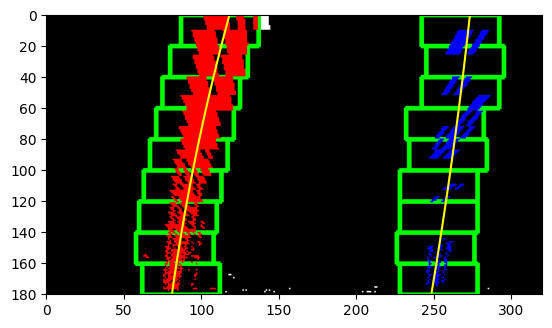

In [191]:
detector(binary_sub, ploty, visualization= True)

In [36]:
def window_search(left_fit, right_fit, binary_warped, margin=100, visualization=False):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    if visualization:
        
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        out_img = out_img.astype('uint8')
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim((0, frame_width / input_scale))
        plt.ylim((frame_height / input_scale, 0))

        plt.show()

    return left_fit, right_fit
    #return plt.imshow(result)


In [37]:
def tracker(binary_sub, ploty, visualization=False):

    left_fit, right_fit = window_search(left_lane.prev_poly, right_lane.prev_poly, binary_sub, margin=100/input_scale, visualization=visualization)

    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]

    std_value = np.std(right_fitx - left_fitx)
    if std_value < (85 /input_scale):
        left_lane.detected = True
        right_lane.detected = True
        left_lane.current_poly = left_fit
        right_lane.current_poly = right_fit
        left_lane.cur_fitx = left_fitx
        right_lane.cur_fitx = right_fitx
        
    else:
        left_lane.detected = False
        right_lane.detected = False
        left_lane.current_poly = left_lane.prev_poly
        right_lane.current_poly = right_lane.prev_poly
        left_lane.cur_fitx = left_lane.prev_fitx[-1]
        right_lane.cur_fitx = right_lane.prev_fitx[-1]

In [146]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
binary_sub = np.zeros_like(binary_warped)
binary_sub[:, int(150/input_scale):int(-80/input_scale)]  = binary_warped[:, int(150/input_scale):int(-80/input_scale)]


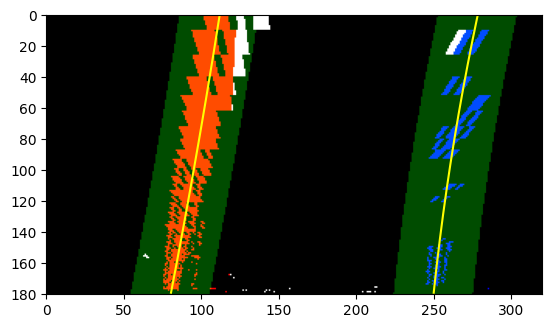

In [147]:
tracker(binary_sub, ploty, visualization= True)

### **Calculate curvature**

Use the radius of curvature formula to calculate


In [40]:
Image(url = "formula.png")

In [47]:
def measure_lane_curvature(ploty, leftx, rightx, visualization=False):

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

     # choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/(frame_height/input_scale) # meters per pixel in y dimension
    xm_per_pix = LANEWIDTH/(700/input_scale) # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # print(left_curverad, 'm', right_curverad, 'm')

    if leftx[0] - leftx[-1] > 50/input_scale:
        curve_direction = 'Left curve'
    elif leftx[-1] - leftx[0] > 50/input_scale:
        curve_direction = 'Right curve'
    else:
        curve_direction = 'Straight'

    return (left_curverad+right_curverad)/2.0, curve_direction


### **Tracking the center of the car**

Define off_center function that return whether the car is off center or not. Assuming the camera is placed at the center of the car. Set a limit from that center to the left and right lane. If that limit is broken, then the function will trigger warining.

In [42]:
def off_center(left, mid, right):
    

    a = mid - left
    b = right - mid
    width = right - left

    if a >= b:  # driving right off
        offset = a / width * LANEWIDTH - LANEWIDTH /2.0
    else:       # driving left off
        offset = LANEWIDTH /2.0 - b / width * LANEWIDTH

    return offset


def compute_car_offcenter(ploty, left_fitx, right_fitx, undist):

    # Create an image to draw the lines on
    height = undist.shape[0]
    width = undist.shape[1]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    bottom_l = left_fitx[height-1]
    bottom_r = right_fitx[0]

    offcenter = off_center(bottom_l, width/2.0, bottom_r)

    return offcenter, pts


Define create_output_frame that generate a frame contains all the image.

In [43]:
def create_output_frame(offcenter, pts, undist_ori, fps, curvature,curve_direction, binary_sub, threshold=0.6):
    
    undist_ori = cv2.resize(undist_ori, (0,0), fx=1/output_frame_scale, fy=1/output_frame_scale)
    w = undist_ori.shape[1]
    h = undist_ori.shape[0]

    undist_birdview = warper(cv2.resize(undist_ori, (0,0), fx=1/2, fy=1/2), M_b)

    color_warp = np.zeros_like(undist_ori).astype(np.uint8)

    # create a frame to hold every image
    whole_frame = np.zeros((np.int(h*2.5),np.int(w*2.34), 3), dtype=np.int8)


    if abs(offcenter) > threshold:  # car is offcenter more than 0.6 m
        # Draw Red lane
        cv2.fillPoly(color_warp, np.int_([pts]), (255, 0, 0)) # red
    else: # Draw Green lane
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))  # green

    newwarp = cv2.warpPerspective(color_warp, M_inv, (int(frame_width/input_scale), int(frame_height/input_scale)))

    # Combine the result with the original image    # result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    newwarp_ = cv2.resize(newwarp,None, fx=input_scale/output_frame_scale, fy=input_scale/output_frame_scale, interpolation = cv2.INTER_LINEAR)

    output = cv2.addWeighted(undist_ori, 1, newwarp_, 0.3, 0)

    whole_frame[40:40+h, 20:20+w, :] = undist_ori
    whole_frame[40:40+h, 60+w:60+2*w, :] = output
    whole_frame[np.int(220+h/2):np.int(220+2*h/2), np.int(20):np.int(20+w/2), :] = undist_birdview
    whole_frame[np.int(220+h/2):np.int(220+2*h/2), np.int(40+w/2):np.int(40+w), 0] = cv2.resize((binary_sub*255).astype(np.uint8), (0,0), fx=1/2, fy=1/2)
    whole_frame[np.int(220+h/2):np.int(220+2*h/2), np.int(40+w/2):np.int(40+w), 1] = cv2.resize((binary_sub*255).astype(np.uint8), (0,0), fx=1/2, fy=1/2)
    whole_frame[np.int(220+h/2):np.int(220+2*h/2), np.int(40+w/2):np.int(40+w), 2] = cv2.resize((binary_sub*255).astype(np.uint8), (0,0), fx=1/2, fy=1/2)

    font = cv2.FONT_HERSHEY_SIMPLEX
    if offcenter >= 0:
        offset = offcenter
        direction = 'Right'
    elif offcenter < 0:
        offset = -offcenter
        direction = 'Left'

    info_road = "Road Status"
    info_lane = "Lane info: {0}".format(curve_direction)
    info_cur = "Curvature {:6.1f} m".format(curvature)
    info_offset = "Off center: {0} {1:3.1f}m".format(direction, offset)
    info_framerate = "{0:4.1f} fps".format(fps)
    info_warning = "Warning: offcenter > 0.6m (use higher threshold in real life)"

    cv2.putText(whole_frame, "Departure Warning System with a Monocular Camera", (23,25), font, 0.8, (255,255,0), 1, cv2.LINE_AA)
    cv2.putText(whole_frame, "Origin", (22,70), font, 0.6, (255,255,0), 1, cv2.LINE_AA)
    cv2.putText(whole_frame, "Augmented", (40+w+25,70), font, 0.6, (255,255,0), 1, cv2.LINE_AA)
    cv2.putText(whole_frame, "Bird's View", (22+30,70+35+h), font, 0.6, (255,255,0), 1, cv2.LINE_AA)
    cv2.putText(whole_frame, "Lanes", (22+225,70+35+h), font, 0.6, (255,255,0), 1, cv2.LINE_AA)
    cv2.putText(whole_frame, info_road, (40+w+50,70+35+h), font, 0.8, (255,255,0), 1,cv2.LINE_AA)
    cv2.putText(whole_frame, info_warning, (35+w,60+h), font, 0.4, (255,255,0), 1,cv2.LINE_AA)
    cv2.putText(whole_frame, info_lane, (40+w+50,70+35+40+h), font, 0.8, (255,255,0), 1,cv2.LINE_AA)
    cv2.putText(whole_frame, info_cur, (40+w+50,70+35+80+h), font, 0.8, (255,255,0), 1,cv2.LINE_AA)
    cv2.putText(whole_frame, info_offset, (40+w+50,70+35+120+h), font, 0.8, (255,255,0), 1,cv2.LINE_AA)
    cv2.putText(whole_frame, info_framerate, (40+w+250,70), font, 0.6, (255,255,0), 1,cv2.LINE_AA)

    return whole_frame


### **Combine all previous functions into one frame**

Define function create_output_frame to extract the results from previous function:
1. gradient_pipeline(): generate binary image
3. warper(): give the bird view
4. measure_lane_curvature(): calculate the curvature
5. create_output_frame(): visualize above results 
6. offcenter(): give warning when car off center
7. detector(): detec the lane
8. tracker(): trace the lane

In [192]:
def process_frame(img, visualization=False):

    start = timer()
    # resize the input image according to scale
    img_undist_ = cv2.undistort(img, mtx, dist, None, mtx)
    img_undist = cv2.resize(img_undist_, (0,0), fx=1/input_scale, fy=1/input_scale)

    # find the binary image of lane/edges
    img_binary = find_edges(img_undist)

    # warp the image to bird view
    binary_warped = warper(img_binary, M)  # get binary image contains edges

    # crop the binary image
    binary_sub = np.zeros_like(binary_warped)
    binary_sub[:, int(150/input_scale):int(-80/input_scale)]  = binary_warped[:, int(150/input_scale):int(-80/input_scale)]

    # start detector or tracker to find the lanes
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    if left_lane.detected:  # start tracker
        tracker(binary_sub, ploty, visualization)
    else:  # start detector
        detector(binary_sub, ploty, visualization)

    # average among the previous N frames to get the averaged lanes
    left_lane.process(ploty)
    right_lane.process(ploty)

    # measure the lane curvature
    curvature, curve_direction = measure_lane_curvature(ploty, left_lane.mean_fitx, right_lane.mean_fitx)

    # compute the car's off-center in meters
    offcenter, pts = compute_car_offcenter(ploty, left_lane.mean_fitx, right_lane.mean_fitx, img_undist)

    # compute the processing frame rate
    end = timer()
    fps = 1.0 / (end - start)

    # combine all images into final video output (only for visualization purpose)
    #output = create_output_frame(offcenter, pts, img_undist_, fps, curvature, curve_direction, binary_sub)
    output = create_output_frame(offcenter, pts, img_undist_, fps,  curvature,curve_direction, binary_sub)
    return output
    #return detector
    #return detector




In [195]:
from IPython.display import Video

## **Result**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


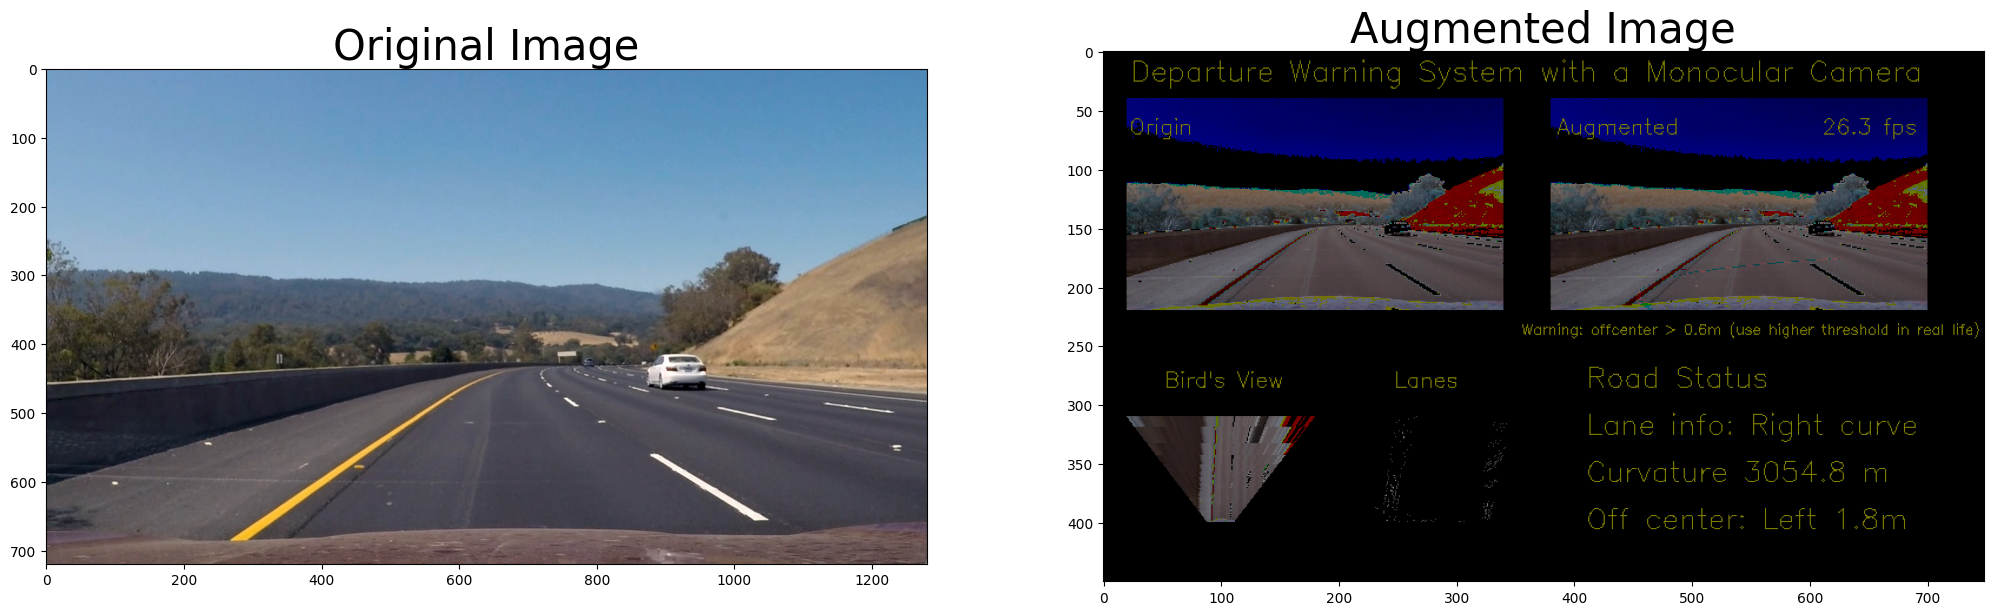

In [211]:
from lane import *
from moviepy.editor import VideoFileClip


if __name__ == "__main__":

    demo = 1 

    if demo == 1:
        imagepath = 'examples/test3.jpg'
        img = cv2.imread(imagepath)
        img_aug = process_frame(img)

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 9))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=30)
        #img_aug = cv2.cvtColor(img_aug, cv2.COLOR_BGR2RGB)
        ax2.imshow(img_aug)
        ax2.set_title('Augmented Image', fontsize=30)
        plt.show()

    else:
        video_output = 'examples/project_video_augmented.mp4'
        clip1 = VideoFileClip("examples/project_video.mp4")

        clip = clip1.fl_image(process_frame) 
        clip.write_videofile(video_output, audio=False)


Here is the link to Google Drive for the result Videos:
https://drive.google.com/drive/folders/1fDBRG4eTqWm3glP5w9dHkSSvc64j5joc?usp=sharing

## **Downsides**

There are sill many downsides of the program:
1. This use 1280x720 resolution videos. Hence, the input videos have to be converted to that resolution. Hence, it is not universal resolution.
2. The detection is not good, or does not work when there is 
* bad lightning conditions (at night), shadow (blur out the white and yellow lanes in binary image), 
* motorcycle (rapid of changing in lanes and continously off center), 
* no lane (the histogram does not detect enough density in pixle)
3. Too many pre-determined parameter, such as lane width, source points and destination points for bird view. These parameter will change base on the dimension of car or camera placement. Also, these parementers are rounded for quick calculation, therefore, sensitive to errors.

## **Further Applications**

After we can improve all the previous downsides. There are plenty of useful application can be applied:
1. Can combine with steering assist, when the off-center detect the car is off center, signal will be sent to steer the car back to center. This can also work when there is a dectection of another car merging in to front at unsafte distance, the car auto steer away or apply break.
2. If we add front car detection paramenter, where the program can detect there is a car in front base on the car's speed, front car's speed, and distance between 2 cars. If the program detect the front car is closer than safety permitted, emergency brake will applied or warning sound. 